In [1]:
import numpy as np   # Importo paquete de álgebra lineal
import matplotlib.pyplot as plt   # Importo paquete de gráficos
import copy
import mef
plt.rc('figure', figsize=(15,8))   # Para gráficos
plt.rc('font',size=22)             # Para gráficos

## Punto 2

Considere el entramado mostrado en la figura, con una fuerza aplicada de $20\:kN$. Calcule los desplazamientos de cada uno de los nodos y las tensiones que sufre cada elemento. Todos los elementos tienen $E = 210\:GPa$ y una sección de $10\:cm^2$, excepto el elemento 3, que tiene una sección de $20\:cm^2$. Los elementos 2 y 5 tienen una longitud de $8\:m$ y el elemento 3 de $4\:m$.
<center><img src="ImgProb02.png"></center>

In [2]:
# Defino la matriz de nodos "MN".
# - Columna 1 es la coordenada "x" del nodo.
# - Columna 2 es la coordenada "y" del nodo.
# - Columna 3 es la coordenada "z" del nodo.
MN = np.array([[0,0,0],
               [8,0,0],
               [16,0,0],
               [8,4,0]])

# Su número de filas es el número de NODOS "Nn".
Nn = MN.shape[0]

In [3]:
# Defino la matriz de conectividad "MC".
# Informa qué nodos componen a cada elemento.
MC= np.array([[0,3],
              [0,1],
              [1,3],
              [2,3],
              [1,2]])

# Su número de filas es el número de ELEMENTOS "Ne".
# Su número de columnas es el número NODOS POR ELEMENTO "Nnxe".
Ne, Nnxe = MC.shape

In [4]:
# Defino los grados de libertad por nodo "glxn".
glxn = 2

In [5]:
# Defino el módulo de elasticidad "E" de cada elemento.
E = np.array([210,210,210,210,210])*1e9   # Pa

# Defino la sección "A" de cada elemento.
A = np.array([10,10,20,10,10])*1e-4   # m^2

### Condiciones de vínculo en DESPLAZAMIENTO
- $x_0 = 0\: m$
- $y_0 = 0\: m$
- $y_2 = 0\: m$

### Condiciones de vínculo en FUERZA
- $F_{1x} = 0\: kN$
- $F_{1y} = -20\: kN$
- $F_{2x} = 0\: kN$
- $F_{3x} = 0\: kN$
- $F_{3y} = 0\: kN$

In [6]:
# Defino vector "s" que contiene los nodos con condiciones de vínculo en desplazamiento.
s = np.array([0,1,5])

# Defino vector "Us" con los valores de las condiciones de vínculo.
Us = [[0],[0],[0]]

# Defino vector "r" que contiene los nodos con condiciones de vínculo en fuerza. Es el complemento de "s".
r = np.array([i for i in range(Nn*glxn) if i not in s])

# Defino vector "Fr" con los valores de las condiciones de vínculo.
Fr = [[0],[-20000],[0],[0],[0]]

## Resolución

In [7]:
# Llamo al paquete "mef", que contiene la función "Kglobal" que calcula la matriz global "K".
K = mef.Kglobal(MN, MC, E, A, glxn)

In [8]:
# Llamo al paquete "mef", que contiene la función "solve" que calcula los vectores de fuerzas "F" y de desplazamientos 
# "U", empleando MEF. 
F, U = mef.solve(K, r, Fr, s, Us)

In [9]:
print('Las FUERZAS (en N) son:')
print(F)
print('Los DESPLAZAMIENTOS (en m) son:')
print(U)

Las FUERZAS (en N) son:
[[ 7.27595761e-12]
 [ 1.00000000e+04]
 [ 0.00000000e+00]
 [-2.00000000e+04]
 [ 0.00000000e+00]
 [ 1.00000000e+04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
Los DESPLAZAMIENTOS (en m) son:
[[ 0.        ]
 [ 0.        ]
 [ 0.0007619 ]
 [-0.00384387]
 [ 0.00152381]
 [ 0.        ]
 [ 0.0007619 ]
 [-0.0036534 ]]


In [10]:
# FORMA MÁS LINDA DE PRESENTAR LOS DATOS:
# - "%s" significa que te pone número entero.
# - "%.4f" significa que te pone número con 4 cifras decimales.
# - "%2.4f" y "%7.4f" sólo varían en que con "7" te pone los números alineados respecto del "=" y queda más lindo si 
# llega  a haber uno con signo "-".
for nodo in range(Nn):
    print('Nodo %s     Ux = %2.4f mm     Uy = %7.4f mm     Fx = %2.4f N     Fy = %7.4f N'%(nodo+1, U[2*nodo]*1000, U[2*nodo+1]*1000, F[2*nodo], F[2*nodo+1]))

Nodo 1     Ux = 0.0000 mm     Uy =  0.0000 mm     Fx = 0.0000 N     Fy = 10000.0000 N
Nodo 2     Ux = 0.7619 mm     Uy = -3.8439 mm     Fx = 0.0000 N     Fy = -20000.0000 N
Nodo 3     Ux = 1.5238 mm     Uy =  0.0000 mm     Fx = 0.0000 N     Fy = 10000.0000 N
Nodo 4     Ux = 0.7619 mm     Uy = -3.6534 mm     Fx = 0.0000 N     Fy =  0.0000 N


### Cálculo de TENSIÓN sufrida por cada elemento

Sea un elemento de longitud inicial $L$. Una vez sometido a las fuerzas correspondientes al ejercicio, su longitud variará una cantidad $\Delta L$, por lo que sufrirá una deformación:

$$
\varepsilon = \frac{\Delta L}{L}
$$

Sea $E$ el módulo de elasticidad del elemento, entonces la **tensión** que sufrirá el elemento será:

$$
\sigma = E \varepsilon
$$

**¿Cómo obtengo $\Delta L$ de cada elemento?**
- Sé que $L$ está asociada a las posiciones inciales de los nodos, almacenadas en la matriz de nodos $MN$.
- Sé que luego de aplicadas las fuerzas, los elementos tendrán nuevas longitudes $L_F$ que estarán asociadas a las posiciones finales de los nodos, que sería una nueva matriz de nodos ${MN}'$.

$$
L_F = L + \Delta L \hspace{1cm} ; \hspace{1cm} {MN}' = MN + U^{2D}
$$

, donde $U^{2D}$ son los desplazmientos reexpresados en 2D.

In [11]:
# Convierto el vector de desplazamientos "U" de tamaño "(2*Nn)*1", en un vector "U_2D" de tamaño "Nn*2".
# - Columna "0" contiene desplazamientos en "x".
# - Columna "1" contiene desplazamientos en "y".
U_2D = U.reshape(Nn,2)

# Agrego columna "2" con los desplazamientos en "z", que son nulos.
new_column = np.zeros(Nn).reshape(-1,1)
U_2D = np.append(U_2D, new_column, axis=1)

In [12]:
# Calculo las posiciones finales de los nodos, matriz "MN'".
MN_final = MN + U_2D

In [13]:
# Defino vector "LI" que contendrá la longitud inicial de cada elemento.
LI = np.zeros([Ne,1])

# Defino vector "LF" que contendrá la longitud final de cada elemento.
LF = np.zeros([Ne,1])

for e in range(Ne):
    nodo1 = MC[e, 0]   # Primer nodo que conforma al elemento "e".
    nodo2 = MC[e, 1]   # Segundo nodo que conforma al elemento "e".
    LxI = MN[nodo2, 0] - MN[nodo1, 0]   # Longitud INICIAL en eje "x".
    LyI = MN[nodo2, 1] - MN[nodo1, 1]   # Longitud INICIAL en eje "y".
    LeI = np.sqrt(LxI**2+LyI**2)         # Longitud INICIAL del elemento "e" (calculé la norma).
    LI[e] = LeI
    LxF = MN_final[nodo2, 0] - MN_final[nodo1, 0]   # Longitud en eje "x".
    LyF = MN_final[nodo2, 1] - MN_final[nodo1, 1]   # Longitud en eje "y".
    LeF = np.sqrt(LxF**2+LyF**2)         # Longitud FINAL del elemento "e" (calculé la norma).
    LF[e] = LeF

In [14]:
# Calculo "deltaL" de cada elemento.
deltaL = LF - LI

In [15]:
eps = np.zeros([Ne,1])    # "eps" almacena deformación de cada elemento.
sigma = np.zeros([Ne,1])  # "sigma" almacena tensión de cada elemento.
for i in range(Ne):
    eps[i] = (deltaL[i])/(LI[i])
    sigma[i] = eps[i]*E[i]

In [16]:
print('Las TENSIONES (en Pa) son:')
print(sigma)

Las TENSIONES (en Pa) son:
[[-22343588.17302767]
 [ 20024238.53052049]
 [ 10000000.00000556]
 [-22343588.17302767]
 [ 20024238.53052049]]


In [17]:
for e in range(Ne):
    print('Elemento %s     Tensión = %2.4f MPa'%(e+1, sigma[e]/(1e6)))

Elemento 1     Tensión = -22.3436 MPa
Elemento 2     Tensión = 20.0242 MPa
Elemento 3     Tensión = 10.0000 MPa
Elemento 4     Tensión = -22.3436 MPa
Elemento 5     Tensión = 20.0242 MPa


<div style="background:#999900">por que nadia hace el dibujito?</div>

In [18]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12,8))
plt.rc('font', size=20)

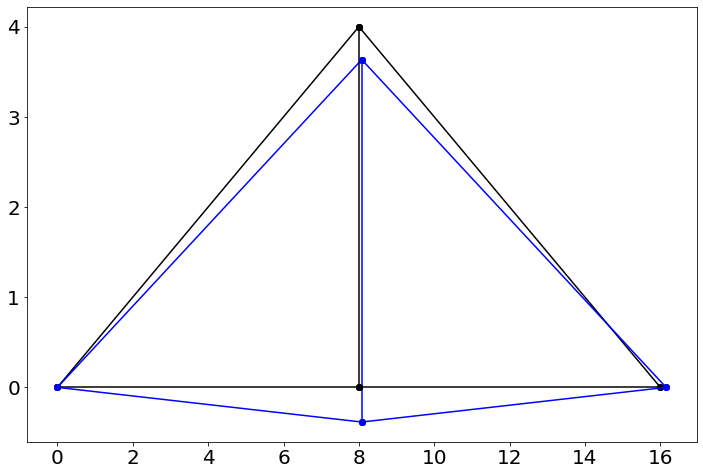

In [20]:

DXY = np.reshape(U, (len(MN),2))

MND = MN + U_2D*100

fig, ax = plt.subplots()
for L in MC:
    ax.plot(MN[L,0], MN[L,1], '-ok')
    ax.plot(MND[L,0], MND[L,1], '-ob')